In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt, textwrap
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("../Datasets/UberRaw-data-apr14.csv")
df

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
564511,4/30/2014 23:22:00,40.7640,-73.9744,B02764
564512,4/30/2014 23:26:00,40.7629,-73.9672,B02764
564513,4/30/2014 23:31:00,40.7443,-73.9889,B02764
564514,4/30/2014 23:32:00,40.6756,-73.9405,B02764


# Data cleaning And Feature Engineerig

In [3]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M:%S', errors='coerce')
df = df.dropna(subset=['Date/Time']).sort_values('Date/Time').reset_index(drop=True)

# Broad NYC bounds sanity filter
df = df[df['Lat'].between(40.0, 41.2) & df['Lon'].between(-74.5, -72.8)].copy()

# Hourly aggregation (citywide pickups)
hourly = (
    df.set_index('Date/Time')
      .resample('H').size()
      .to_frame('pickups')
      .reset_index()
)


C:\Users\tusha\AppData\Local\Temp\ipykernel_36784\2734687910.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H').size()


In [4]:
# Time features
hourly['hour'] = hourly['Date/Time'].dt.hour
hourly['day'] = hourly['Date/Time'].dt.day
hourly['weekday'] = hourly['Date/Time'].dt.dayofweek
hourly['is_weekend'] = hourly['weekday'].isin([5,6]).astype(int)

# Cyclical encodings
hourly['hour_sin'] = np.sin(2*np.pi*hourly['hour']/24)
hourly['hour_cos'] = np.cos(2*np.pi*hourly['hour']/24)
hourly['wday_sin'] = np.sin(2*np.pi*hourly['weekday']/7)
hourly['wday_cos'] = np.cos(2*np.pi*hourly['weekday']/7)


In [5]:
# 5) Lags & rolling means (causal: shift before rolling)
hourly["lag_1"]       = hourly["pickups"].shift(1)
hourly["lag_24"]      = hourly["pickups"].shift(24)
hourly["roll_mean_6"] = hourly["pickups"].shift(1).rolling(6).mean()
hourly["roll_mean_24"]= hourly["pickups"].shift(1).rolling(24).mean()


In [6]:
hourly_model = hourly.dropna().reset_index(drop=True)


In [7]:
df = hourly_model.copy()

In [8]:
cols = ["Date/Time","pickups","hour","day","weekday","is_weekend",
        "hour_sin","hour_cos","wday_sin","wday_cos",
        "lag_1","lag_24","roll_mean_6","roll_mean_24"]
df = df[cols]

# EDA

# Uber NYC Pickups per Hour

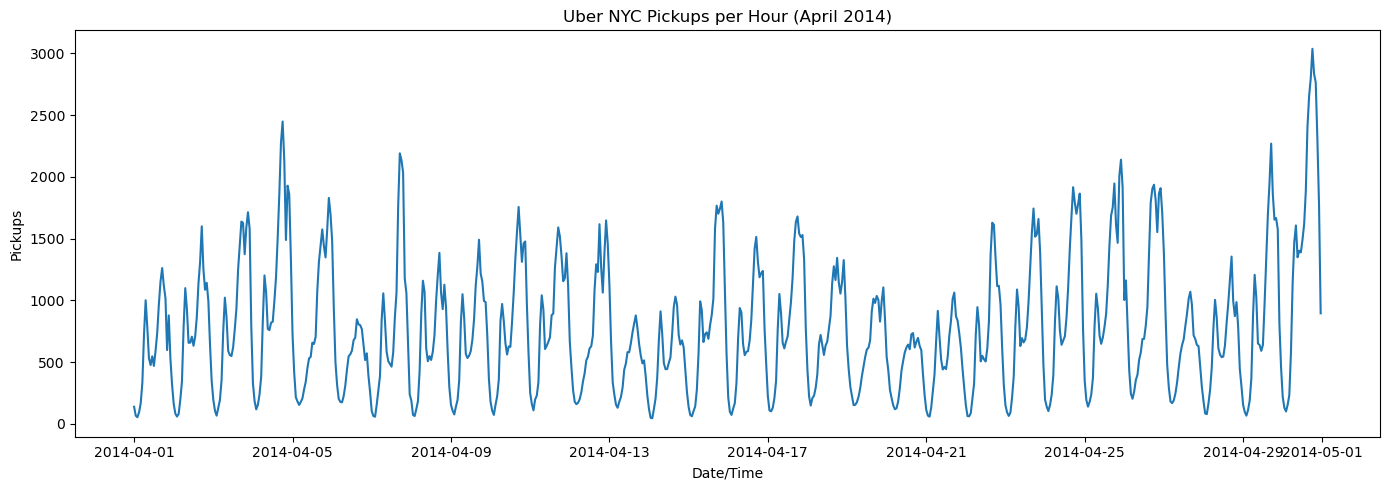

In [9]:
plt.figure(figsize=(14,5))
plt.plot(hourly['Date/Time'], hourly['pickups'])
plt.title('Uber NYC Pickups per Hour (April 2014)')
plt.xlabel('Date/Time'); plt.ylabel('Pickups'); plt.tight_layout()
plt.show()


# Average Pickups by Hour of Day

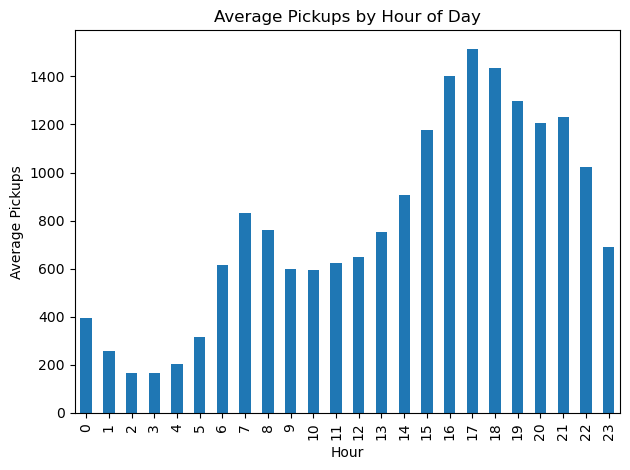

In [10]:
plt.figure()
hourly.groupby('hour')['pickups'].mean().plot(kind='bar')
plt.title('Average Pickups by Hour of Day')
plt.xlabel('Hour'); plt.ylabel('Average Pickups'); plt.tight_layout()
plt.show()

# Average Pickups by Weekday 

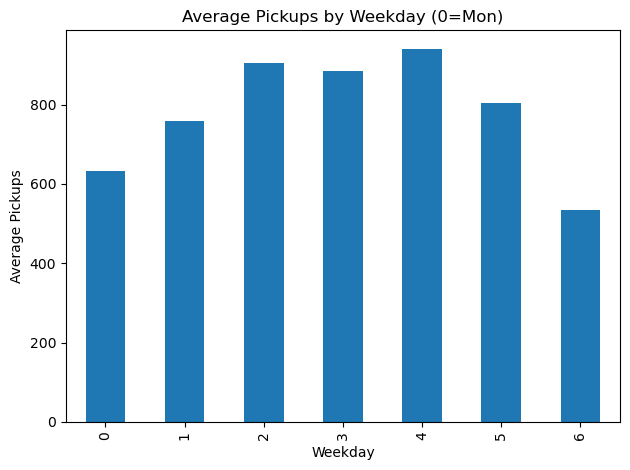

In [11]:
plt.figure()
hourly.groupby('weekday')['pickups'].mean().plot(kind='bar')
plt.title('Average Pickups by Weekday (0=Mon)')
plt.xlabel('Weekday'); plt.ylabel('Average Pickups'); plt.tight_layout()
plt.show()

# Pickup Density Across NYC (Hexbin)

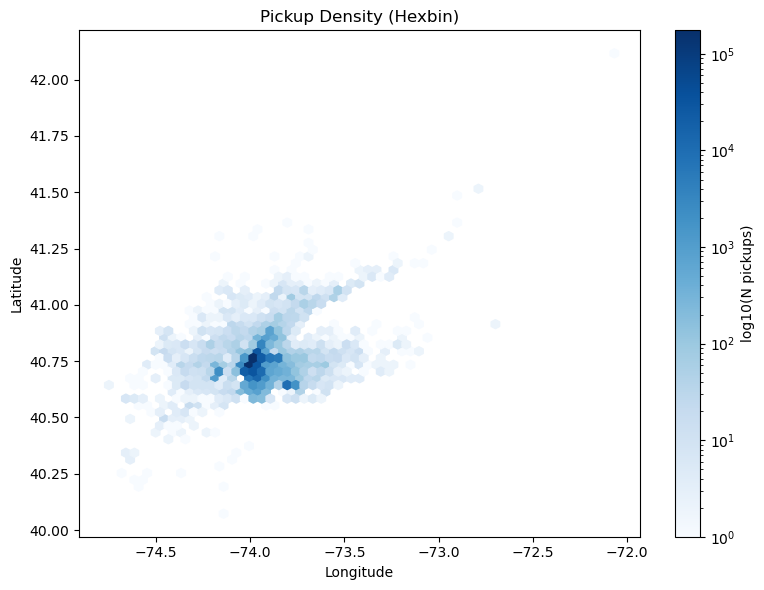

In [12]:
# Reload raw dataset or keep a copy earlier
raw = pd.read_csv("../Datasets/UberRaw-data-apr14.csv")
raw['Date/Time'] = pd.to_datetime(raw['Date/Time'], format='%m/%d/%Y %H:%M:%S')

# Pickup density hexbin
plt.figure(figsize=(8,6))
plt.hexbin(raw['Lon'], raw['Lat'], gridsize=60, bins='log', cmap='Blues')
plt.title('Pickup Density (Hexbin)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.colorbar(label='log10(N pickups)')
plt.tight_layout()
plt.show()


# “Trips by Uber Base”



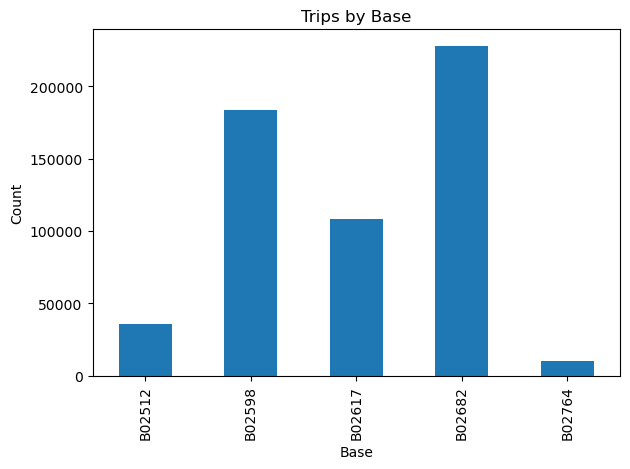

In [13]:
plt.figure()
raw = pd.read_csv("../Datasets/UberRaw-data-apr14.csv")
raw['Date/Time'] = pd.to_datetime(raw['Date/Time'], format='%m/%d/%Y %H:%M:%S')

raw['Base'].value_counts().sort_index().plot(kind='bar')
plt.title('Trips by Base')
plt.xlabel('Base'); plt.ylabel('Count'); plt.tight_layout()
plt.show()

# Train Test Split

In [14]:
X = df.drop(['pickups','Date/Time'],axis=1).values 
y = df['pickups'].values

In [15]:
tscv = TimeSeriesSplit(n_splits=5,test_size=20)
results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    Xtrain, Xtest = X[train_idx], X[test_idx]
    ytrain, ytest = y[train_idx], y[test_idx]    

In [16]:
scaler=StandardScaler()

In [17]:
Xtrain_scaled =scaler.fit_transform(Xtrain)
Xtest_scaled =scaler.transform(Xtest)

# Random Forest

In [18]:
model = RandomForestRegressor(random_state=42,n_jobs=1)
model.fit(Xtrain_scaled,ytrain)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
y_pred_test=model.predict(Xtest_scaled)
y_pred_train=model.predict(Xtrain_scaled)

In [20]:
def evaluate_model(model, Xtrain, ytrain, Xtest, ytest, name="Model"):
    y_pred_train = model.predict(Xtrain)
    y_pred_test  = model.predict(Xtest)

    # Compute metrics
    metrics = {
        'model': name,
        'train_RMSE': np.sqrt(mean_squared_error(ytrain, y_pred_train)),
        'test_RMSE': np.sqrt(mean_squared_error(ytest, y_pred_test)),
        'train_MAE': mean_absolute_error(ytrain, y_pred_train),
        'test_MAE': mean_absolute_error(ytest, y_pred_test),
        'train_R2': r2_score(ytrain, y_pred_train),
        'test_R2': r2_score(ytest, y_pred_test)
    }

    return metrics, y_pred_test



In [21]:
results, predictions = evaluate_model(model, Xtrain_scaled, ytrain, Xtest_scaled, ytest, "RandomForest")
print(results)


{'model': 'RandomForest', 'train_RMSE': np.float64(45.858564692119415), 'test_RMSE': np.float64(485.2651472288114), 'train_MAE': 29.210650887573966, 'test_MAE': 388.71950000000004, 'train_R2': 0.9917613901385726, 'test_R2': 0.6044152812179161}


# Hyperparameter for Random Forest

In [22]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_grid = {
    'n_estimators': [150, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
}
tscv = TimeSeriesSplit(n_splits=5,test_size=20)
rf_cv = GridSearchCV(
    estimator=rf,
    param_grid=rf_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
rf_cv.fit(Xtrain_scaled, ytrain)
best_rf = rf_cv.best_estimator_
print("Best Params:", rf_cv.best_params_)
print('Best parameters:', rf_cv.best_params_)
print('Best RMSE:', np.sqrt(-rf_cv.best_score_))



Best Params: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best RMSE: 12.251662344649652


# Deep Learning

In [23]:
model_mlp=MLPRegressor(max_iter=700,random_state=42)
model_mlp.fit(Xtrain_scaled,ytrain)

C:\Users\tusha\anaconda3\envs\Tusharenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


,loss,'squared_error'
,hidden_layer_sizes,"(100,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,700
,shuffle,True


In [24]:
def evaluate_model(model, Xtrain_scaled, ytrain, Xtest_scaled, ytest, name="model"):
    y_pred = model.predict(Xtest_scaled)
    y_pred_Train = model.predict(Xtrain_scaled)

    metrics= {
        'model': name,
        'train_RMSE': np.sqrt(mean_squared_error(ytrain, y_pred_Train)),
        'test_RMSE': np.sqrt(mean_squared_error(ytest, y_pred)),
        'train_MAE': mean_absolute_error(ytrain, y_pred_Train),
        'test_MAE': mean_absolute_error(ytest, y_pred),
        'train_R2': r2_score(ytrain, y_pred_Train),
        'test_R2': r2_score(ytest, y_pred)
    }
    return metrics,y_pred


In [25]:
results, predictions = evaluate_model(model, Xtrain_scaled, ytrain, Xtest_scaled, ytest, "MLPRegressor")
print(results)

{'model': 'MLPRegressor', 'train_RMSE': np.float64(45.858564692119415), 'test_RMSE': np.float64(485.2651472288114), 'train_MAE': 29.210650887573966, 'test_MAE': 388.71950000000004, 'train_R2': 0.9917613901385726, 'test_R2': 0.6044152812179161}


In [27]:
mlp = MLPRegressor(max_iter=700, random_state=42)
mlp_grid = {'hidden_layer_sizes':[(64,32),(128,64),(128,64,32)],
            'activation':['relu','tanh'],
            'alpha':[1e-4, 1e-3, 1e-2],
            'learning_rate_init':[1e-3, 1e-2]}
mlp_cv = GridSearchCV(mlp, mlp_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
mlp_cv.fit(Xtrain_scaled, ytrain)
best_mlp = mlp_cv.best_estimator_
print("Best Params:",mlp_cv.best_params_)
print('Best parameters:', mlp_cv.best_params_)
print('Best RMSE:', np.sqrt(-mlp_cv.best_score_))




Best Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001}
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001}
Best RMSE: 12.406549557039188


C:\Users\tusha\anaconda3\envs\Tusharenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


# Compare & visualize predictions

# Actual vs Predicted Hourly Pickups

In [28]:
rf_metrics, rf_pred = evaluate_model(best_rf, Xtrain_scaled, ytrain, Xtest_scaled, ytest, name="RandomForest")
mlp_metrics, mlp_pred = evaluate_model(best_mlp, Xtrain_scaled, ytrain, Xtest_scaled, ytest, name="NeuralNet MLP")

print(rf_metrics)
print(mlp_metrics)


{'model': 'RandomForest', 'train_RMSE': np.float64(75.86543063651163), 'test_RMSE': np.float64(496.64506395441066), 'train_MAE': 51.826128674075264, 'test_MAE': 394.31469403384915, 'train_R2': 0.9774523711984068, 'test_R2': 0.5856440756326915}
{'model': 'NeuralNet MLP', 'train_RMSE': np.float64(111.34616376181512), 'test_RMSE': np.float64(300.3272263105562), 'train_MAE': 72.92547441166926, 'test_MAE': 266.9906672828962, 'train_R2': 0.9514305104394691, 'test_R2': 0.8484797368036402}


In [29]:
metrics_df = pd.DataFrame([ rf_metrics, mlp_metrics]).sort_values('test_RMSE').reset_index(drop=True)
best_name = metrics_df.loc[0,'model']
best_pred = {'RandomForest (tuned)':rf_pred,
             'NeuralNet MLP (tuned)':mlp_pred}


In [30]:
results, best_pred = evaluate_model(model, Xtrain_scaled, ytrain, Xtest_scaled, ytest, name="RandomForest")


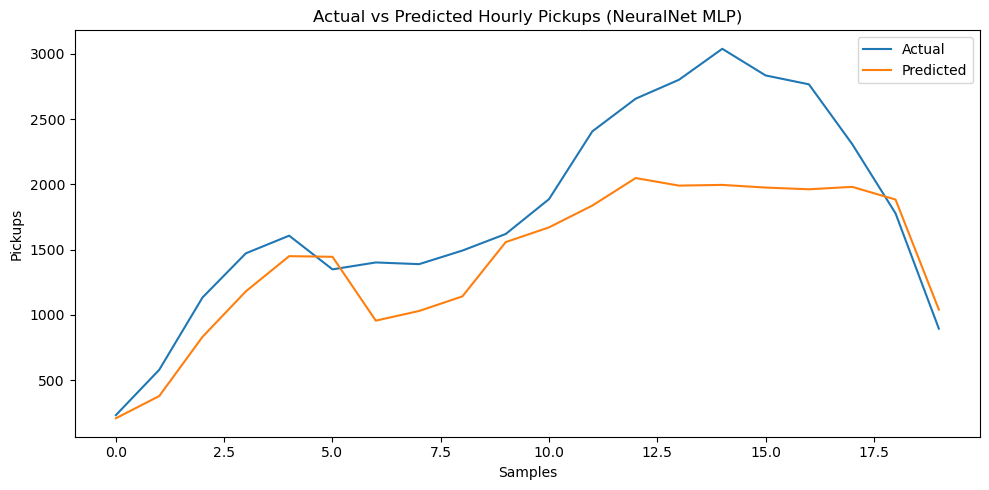

In [31]:
plt.figure(figsize=(10,5))
plt.plot(range(len(ytest)), ytest, label='Actual')
plt.plot(range(len(best_pred)), best_pred, label='Predicted')
plt.title(f'Actual vs Predicted Hourly Pickups ({best_name})')
plt.xlabel('Samples')
plt.ylabel('Pickups')
plt.legend()
plt.tight_layout()
plt.show()


# Random Forest Feature Importance

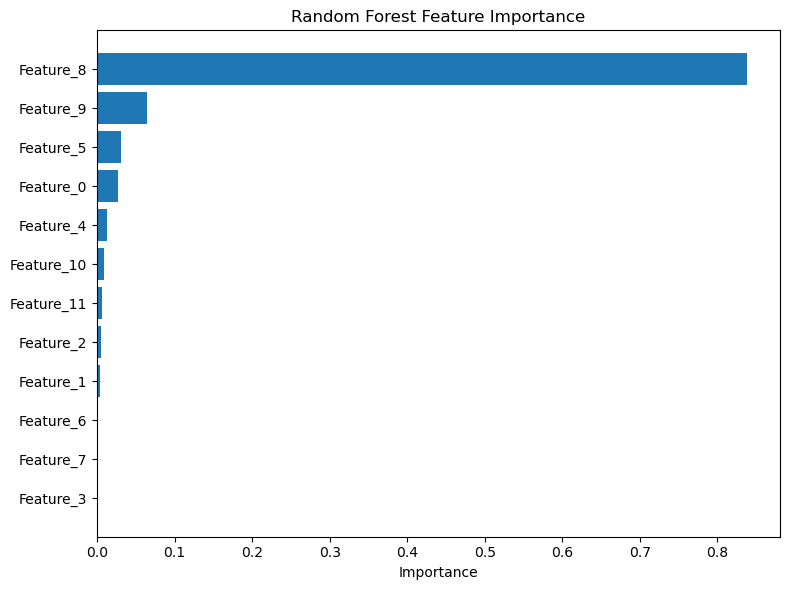

In [32]:
# If you lost feature names, create placeholders
feature_names = [f'Feature_{i}' for i in range(Xtrain.shape[1])]

rf_imp = best_rf.feature_importances_
imp_df = pd.DataFrame({'feature': feature_names, 'importance': rf_imp})
imp_df = imp_df.sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
plt.barh(imp_df['feature'], imp_df['importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


#  Valuable Insights

In [33]:
avg_hour = hourly.groupby('hour')['pickups'].mean()
avg_wday = hourly.groupby('weekday')['pickups'].mean()

In [34]:
peak_hour, peak_val = int(avg_hour.idxmax()), float(avg_hour.max())
low_hour,  low_val  = int(avg_hour.idxmin()), float(avg_hour.min())
best_wday, best_wval = int(avg_wday.idxmax()), float(avg_wday.max())
worst_wday, worst_wval = int(avg_wday.idxmin()), float(avg_wday.min())
top_bases = raw['Base'].value_counts().head(3).to_dict()


In [35]:
rf_rmse = metrics_df.query("model == 'RandomForest'")['test_RMSE'].squeeze()
best_rmse = metrics_df.loc[0, 'test_RMSE']
improve = 100 * (rf_rmse - best_rmse) / rf_rmse



# Summary

In [37]:
# *Insights:**
# - Peak hour: {peak_hour}:00 (~{peak_val:.0f} avg pickups); Low hour: {low_hour}:00 (~{low_val:.0f}).
# - Busiest weekday: {best_wday} (0=Mon) (~{best_wval:.0f}); Slowest: {worst_wday} (~{worst_wval:.0f}).
# - Top bases: {top_bases}
# - Operational levers: staff near peak hours & busy weekdays; use 24h lag/rolling trend signals; target incentives for early morning lull; focus on hexbin hotspots.
